# Final Project Playground

This is just a python notebook where I (Diana) will be exploring the problem more in depth, so as to be able to experiment with a variety of things separate from what is in the baseline.

## Import Libraries and Get Data

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend
from keras.optimizers import SGD

from sklearn.decomposition import PCA

In [188]:
# Get Kaggle Training Data only
kaggle_competition_training_data = pd.read_csv('data/training/training.csv')
print("Kaggle Competition Training Data Shape: ", kaggle_competition_training_data.shape)
kaggle_competition_training_data.head(1)

Kaggle Competition Training Data Shape:  (7049, 31)


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [189]:
# Convert Training data to useful format
# WARNING: This takes quite some time to run
# Loop to re-store all image values in comma separated list object
training_image_list = []
for i in range(len(kaggle_competition_training_data["Image"])):
    training_image_list.append(kaggle_competition_training_data["Image"][i].split(" "))

# reshaping the image list object into array
training_image_array = np.array(training_image_list, dtype = 'float')
len(training_image_array)

7049

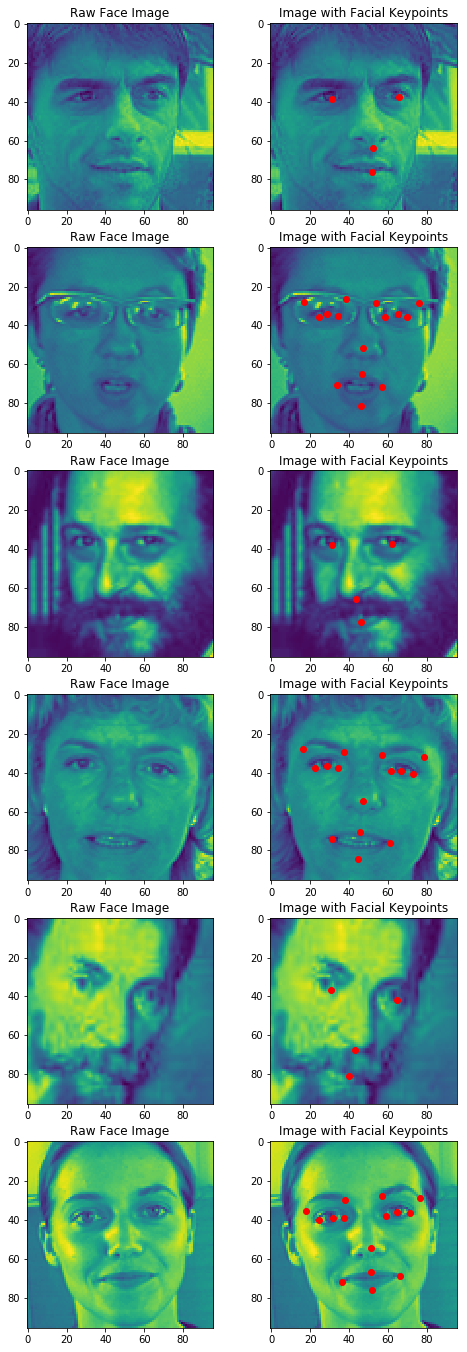

In [190]:
# plotting sample images (good & bad) and associated facial points into 96x96 after reshaping them
feature_list = list(kaggle_competition_training_data)
feature_list.remove("Image")

examples = [7019, 10, 7020, 14, 7021, 23]
num_examples = len(examples)

# Plot raw image (hardcode to the 10th image)
f, images = plt.subplots(num_examples,2, figsize=(8,4*num_examples))

for j in range(0, num_examples):
    example_idx = examples[j]
    #images[j, 0].imshow(training_image_array[example_idx].reshape(96,96), cmap='gray') 
    images[j, 0].imshow(training_image_array[example_idx].reshape(96,96))
    images[j, 0].set_title("Raw Face Image")

    # Plot image with keypoints
    #images[j, 1].imshow(training_image_array[example_idx].reshape(96,96), cmap='gray')
    images[j, 1].imshow(training_image_array[example_idx].reshape(96,96))
    images[j, 1].set_title("Image with Facial Keypoints")
    for i in feature_list[::2]:
        images[j, 1].plot(kaggle_competition_training_data[i[:-1]+'x'][example_idx], 
                          kaggle_competition_training_data[i[:-1]+'y'][example_idx], 'o', color='red')

## Exploration 1: Only look at examples with non-null facial keypoints

For the first phase of exploration, will try to develop a model that solves the problem where we have all 15 facial keypoints defined. Next phase of exploartion will involve looking at images that are missing facial keypoints and how to do feature engineering there. 

### Data Preparation (for non-null data)

In [191]:
# Creating new training dataset with no null values (should be 2140 observations)
isnulls_total = kaggle_competition_training_data[kaggle_competition_training_data.isnull().any(axis=1)]
temp_df = kaggle_competition_training_data
isnulls_column = list(isnulls_total.index)
kaggle_competition_training_data_nonull = temp_df.drop(isnulls_column)

In [270]:
# Convert images and labels to formats needed for model development (will be used throughout)

def ConvertToImagesArray(original_kaggle_data):
    # Extract images 
    new_images_data_list = []
    for i in original_kaggle_data["Image"].index:
        new_images_data_list.append(original_kaggle_data["Image"][i].split(" "))
        
    # Reshaping the image list object into array
    new_images_data = np.array(new_images_data_list, dtype = 'float')
    
    # Convert values to be between 0 and 1
    new_images_data = new_images_data / 255
    
    return new_images_data

def ConvertToLabelsArray(original_kaggle_data):
    # Extract Labels and reshape to array
    new_labels_data = np.array(original_kaggle_data.drop(['Image'], axis=1), dtype='float')
    
    # Convert keypoint values to be between -1 and 1
    new_labels_data = (new_labels_data - 96/2) / (96/2)
    
    return new_labels_data

# Format Images data and Labels data for model development
all_images_nonull = ConvertToImagesArray(kaggle_competition_training_data_nonull)

# Get labels separately into array
all_labels_nonull = ConvertToLabelsArray(kaggle_competition_training_data_nonull)

# Print off final dimensions of data:
print("Dimensions of All Non-null 96x96 Facial Images Array:     " + str(all_images_nonull.shape))
print("Dimensions of All Non-null Facial Keypoints Labels Array: " + str(all_labels_nonull.shape))

print("Images.shape == {}; Images.min == {:.3f}; Images.max == {:.3f}".format(
    all_images_nonull.shape, all_images_nonull.min(), all_images_nonull.max()))
print("Labels.shape == {}; Labels.min == {:.3f}; Labels.max == {:.3f}".format(
    all_labels_nonull.shape, all_labels_nonull.min(), all_labels_nonull.max()))

Dimensions of All Non-null 96x96 Facial Images Array:     (2140, 9216)
Dimensions of All Non-null Facial Keypoints Labels Array: (2140, 30)
Images.shape == (2140, 9216); Images.min == 0.000; Images.max == 1.000
Labels.shape == (2140, 30); Labels.min == -0.920; Labels.max == 0.996


In [262]:
# Split data with non-null keypoints into training & test
# Note: Dev set implicitly split at model training time
train_images_nonull, test_images_nonull, \
train_labels_nonull, test_labels_nonull = train_test_split(all_images_nonull, all_labels_nonull, test_size=0.2, random_state=42, shuffle=True)

print("Dimensions of Training Data: " + str(train_images_nonull.shape))
print("Dimensions of Test Data: " + str(test_images_nonull.shape))

Dimensions of Training Data: (1712, 9216)
Dimensions of Test Data: (428, 9216)


### Modeling (for non-null data)

In [274]:
def PlotModelLoss(model_history):
    train_loss = model_history["loss"]
    dev_loss = model_history["val_loss"]
    train_rmse = model_history["rmse"]
    dev_rmse = model_history["val_rmse"]

    plt.plot(dev_loss, linewidth=3, label="dev-loss")
    plt.plot(train_loss, '--', linewidth=3, label="train-loss")
    plt.plot(dev_rmse, linewidth=3, label="dev-rmse")
    plt.plot(train_rmse, '--', linewidth=3, label="train-rmse")
    
    plt.legend()
    plt.grid()
    #plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("rmse / loss")
    plt.show()
    
# Custom Metrics: RMSE
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis = -1))

In [276]:
# Creating a baseline model with no convolutions (two-layer NN)
model_1_0 = Sequential()
model_1_0.add(Dense(100,input_dim=all_images_nonull.shape[1]))
model_1_0.add(Activation('relu'))
model_1_0.add(Dense(30))

# Since we're being evaluated with RMSE, use mean_squared_error loss
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model_1_0.compile(loss='mean_squared_error', optimizer=sgd, metrics=[rmse])

model_1_0.summary()

hist_1_0 = model_1_0.fit(train_images_nonull, train_labels_nonull, epochs=100, validation_split=0.1,verbose=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 100)               921700    
_________________________________________________________________
activation_35 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________


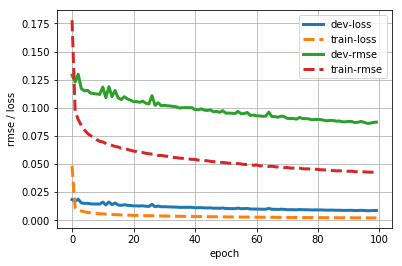

In [277]:
PlotModelLoss(hist_1_0.history)

In [278]:
def ConvertTo2dImagesArray(original_kaggle_data):
    original_kaggle_data_1d = ConvertToImagesArray(original_kaggle_data)
    return np.asarray([original_kaggle_data_1d], dtype=np.uint8).reshape(len(original_kaggle_data_1d),96,96,1)

# Prepare 2D version of data
all_images_2D_nonull = ConvertTo2dImagesArray(kaggle_competition_training_data_nonull)
print("Dimensions of All Non-null 2D 96x96 Facial Images Array:     " + str(all_images_2D_nonull.shape))
print("Dimensions of All Non-null Facial Keypoints Labels Array: " + str(all_labels_nonull.shape))

# Split into train/test
train_images_2D_nonull, test_images_2D_nonull, \
train_labels_nonull, test_labels_nonull = train_test_split(all_images_2D_nonull, all_labels_nonull, test_size=0.2, random_state=42, shuffle=True)

print("Dimensions of Training Data: " + str(train_images_2D_nonull.shape))
print("Dimensions of Test Data: " + str(test_images_2D_nonull.shape))

Dimensions of All Non-null 2D 96x96 Facial Images Array:     (2140, 96, 96, 1)
Dimensions of All Non-null Facial Keypoints Labels Array: (2140, 30)
Dimensions of Training Data: (1712, 96, 96, 1)
Dimensions of Test Data: (428, 96, 96, 1)


In [281]:
# First simple CNN model 
model_1_1 = Sequential()

model_1_1.add(Convolution2D(32, kernel_size=3, activation='relu', input_shape = (96,96,1)))
model_1_1.add(Flatten())
model_1_1.add(Dense(30, activation='relu'))

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model_1_1.compile(loss='mean_squared_error', optimizer=sgd, metrics=[rmse])

model_1_1.summary()

hist_1_1 = model_1_1.fit(train_images_2D_nonull, train_labels_nonull, epochs=10, validation_split=0.1,verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
flatten_7 (Flatten)          (None, 282752)            0         
_________________________________________________________________
dense_77 (Dense)             (None, 30)                8482590   
Total params: 8,482,910
Trainable params: 8,482,910
Non-trainable params: 0
_________________________________________________________________
Train on 1540 samples, validate on 172 samples
Epoch 1/10
1540/1540 [==============================] - 13s 8ms/step - loss: 0.0878 - rmse: 0.2913 - val_loss: 0.0715 - val_rmse: 0.2663
Epoch 2/10
1540/1540 [==============================] - 11s 7ms/step - loss: 0.0690 - rmse: 0.2618 - val_loss: 0.0713 - val_rmse: 0.2659
Epoch 3/10
1540/1540 [==============================] - 11s 7ms/step - loss

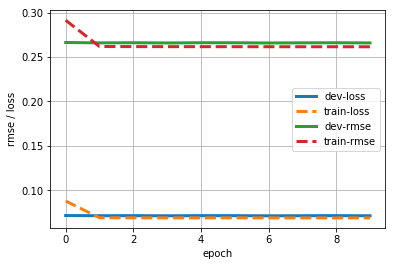

In [282]:
PlotModelLoss(hist_1_1.history)

## Exploration 2: Dealing with the null keypoints

In [197]:
kaggle_competition_training_data.isna().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [310]:
# Convert data to appropriate format
all_images = ConvertToImagesArray(kaggle_competition_training_data)
all_labels = ConvertToLabelsArray(kaggle_competition_training_data)

We have quite a few examples with missing values--it would be best to understand among samples with missing keypoint values, what are the sets of keypoints that are available. Using this information, we can decide on the best way forward (whether to do imputation of missing keypoints based on all the samples that have those missing keypoints, or just fill in averages, etc).

In [311]:
# Get column names to note which keypoints are missing and which are present
keypoint_names = kaggle_competition_training_data.columns[0:30]

# Construct encoding maps for entries with missing values
def CreateEncodingList(labels):
    encoding_list = []
    for r in range(0, len(labels)):
        row = labels[r]

        # Encode 0 if missing, 1 if present
        encoding_vec = ['0' if np.isnan(kp) else '1' for kp in row] 
        encoding = ''.join(encoding_vec)

        # Add to encoding list for all samples
        encoding_list.append(encoding)
    
    return encoding_list
    
def CreateEncodingMap(labels):
    encoding_list = CreateEncodingList(labels)
    
    # Helper function for inserting into encoding map
    def insert(df, row):
        insert_loc = df.index.max()

        if pd.isna(insert_loc):
            df.loc[0] = row
        else:
            df.loc[insert_loc + 1] = row
    
    # Construct encoding map
    encodings_map = pd.DataFrame(columns = ["encoding", "num_kp_missing", "num_kp_present", "missing_kp_names", "present_kp_names", "count"])
    for encoding in encoding_list:
        # Only collect those with missing values
        if ('0' in encoding):        
            # Try to get row for encoding if it exists
            #print(encodings_map['encoding'])
            if (encoding not in encodings_map.encoding.values):
                # Compute necessary entry data
                missing_idx = np.argwhere(np.isnan(row))
                missing_kp_names = ', '.join([i[0] for i in keypoint_names[missing_idx]])
                present_idx = [i for i in range(0,30) if i not in np.argwhere(np.isnan(row))]
                present_kp_names = ', '.join([i for i in keypoint_names[present_idx]])

                # Insert entry
                insert(encodings_map,[encoding, len(missing_idx), len(present_idx), missing_kp_names, present_kp_names,1])
            else:
                # Get Existing Entry
                entry = encodings_map.loc[encodings_map['encoding']==encoding]
                row_num = entry.index[0]

                # Update existing count
                new_count = entry['count'].item() + 1
                encodings_map.at[row_num] = [entry['encoding'].item(), \
                                             entry['num_kp_missing'].item(), \
                                             entry['num_kp_present'].item(), \
                                             entry['missing_kp_names'].item(), \
                                             entry['present_kp_names'].item(), \
                                             new_count]
    return encodings_map
        
encodings_map = CreateEncodingMap(all_labels)
encodings_map

# Save Results to tsv for excel analysis
# encodings_map.to_csv(path_or_buf = "encodings_map.tsv",sep='\t')

,encoding,num_kp_missing,num_kp_present,missing_kp_names,present_kp_names,count
0,111111111111111111111111111100,22,8,"left_eye_inner_corner_x, left_eye_inner_corner...","left_eye_center_x, left_eye_center_y, right_ey...",13
1,111111111111110011111111111111,22,8,"left_eye_inner_corner_x, left_eye_inner_corner...","left_eye_center_x, left_eye_center_y, right_ey...",31
2,111111111111111111001111111111,22,8,"left_eye_inner_corner_x, left_eye_inner_corner...","left_eye_center_x, left_eye_center_y, right_ey...",26
3,110011110000111111111100001111,22,8,"left_eye_inner_corner_x, left_eye_inner_corner...","left_eye_center_x, left_eye_center_y, right_ey...",1
4,111111111111000000001111111111,22,8,"left_eye_inner_corner_x, left_eye_inner_corner...","left_eye_center_x, left_eye_center_y, right_ey...",3
5,110011110000111111111111111111,22,8,"left_eye_inner_corner_x, left_eye_inner_corner...","left_eye_center_x, left_eye_center_y, right_ey...",3
6,111111111111110000001111111111,22,8,"left_eye_inner_corner_x, left_eye_inner_corner...","left_eye_center_x, left_eye_center_y, right_ey...",1
7,111111110000111111111111111111,22,8,"left_eye_inner_corner_x, left_eye_inner_corner...","left_eye_center_x, left_eye_center_y, right_ey...",1
8,111100111111111111111111111111,22,8,"left_eye_inner_corner_x, left_eye_inner_corner...","left_eye_center_x, left_eye_center_y, right_ey...",2
9,111100110011111111111111111111,22,8,"left_eye_inner_corner_x, left_eye_inner_corner...","left_eye_center_x, left_eye_center_y, right_ey...",1


From the results above, we have 48 different "kinds" of missing-value samples. The vast majority (4755/4909) are cases where we only have the right-center eye, left-center eye, nose tip, and mouth center-bottom lip keypoints, which can be argued to be the absolute essential keypoints. If we can compute the missing keypoints for these examples, this will give us a huge boost in training data to help with the model development.

In [312]:
# Prioritize imputing missing facial keypoints for most common case: encoding = 111100000000000000001100000011
P1_encoding = '111100000000000000001100000011'
P1_missing_kp_idx = [i for i in range(0, len(encoding_list_all)) if encoding_list_all[i] == P1_encoding]
print("Number of Priority 1 Missing Keypoints Samples: " + str(len(P1_missing_kp_idx)))

# Get the missing data using the filter index
P1_all_images = all_images[P1_missing_kp_idx]
P1_all_labels = all_labels[P1_missing_kp_idx]
print("Number of Priority 1 Missing Keypoints Samples: " + str(len(P1_all_images)))

Number of Priority 1 Missing Keypoints Samples: 4755
Number of Priority 1 Missing Keypoints Samples: 4755


To help with filling in these missing keypoints, let us leverage the structure of the data with no missing keypoints. For the P1 scenarios we're focusing on, we have 4 keypoints as our ground truth. Among the 2140 samples with no missing keypoinds, we can compute what is the avg distance (in both x and y) between the 4 types of keypoints we have in our missing samples and the other keypoints we have in our nonull samples (we will have this computed in both the x and y direction separately. 

With this information we can construct an 8x22 matrix, where the 8 indicies correspond to each x/y coordinate of the 4 keypoints we have in the P1 samples and the 22 indicies correspond to each x/y coordinate of the 11 keypoints we don't have in the P1 samples but do have in the nonull samples. For each cell at the column index $g$ and row index $m$, we will have an average distance in the x or y direction between the one of the 4 keypoint coordinates $g$ and one of the 11 missing keypoint coordinates $m$ among our nonull samples. 

In [323]:
# Construct the avg matrix for missing keypoint imputation
avg_matrix = np.empty((22, 8), dtype='float')
all_kp_names = [i for i in keypoint_names]
existing_kp_names = ["left_eye_center_x",         "left_eye_center_y", 
                     "right_eye_center_x",        "right_eye_center_y", 
                     "nose_tip_x",                "nose_tip_y", 
                     "mouth_center_bottom_lip_x", "mouth_center_bottom_lip_y"]
missing_kp_names = [x for x in keypoint_names if x not in existing_kp_names]

# work off of all_images_nonull_labels, but shift such that all values are positive for easier imputation
# Labels now between 0 and 2, but computed avgs should be the same
ainl_for_imputation = all_labels_nonull

# Iterate through each column index for the ground truth keypoints to base avgs off of
for g in range(0, 8):
    # Get Coordinates for ground truth keypoint we want to base avgs off of
    g_name = existing_kp_names[g]
    g_ainl_idx = all_kp_names.index(g_name)
    g_ainl_coords = ainl_for_imputation[:, g_ainl_idx]
    #print("Ground Truth Name: " + str(g_name) + ", " + str(g_ainl_idx))
    
    # Iteration through each row index for the missing keypoints to get avgs for
    for m in range(0, 22):
        # Get Coordinates for missing keypoints we want to compute avgs to
        m_name = missing_kp_names[m]
        m_ainl_idx = all_kp_names.index(m_name)
        m_ainl_coords = ainl_for_imputation[:, m_ainl_idx]
        #print("Missing Name: " + str(m_name) + ", " + str(m_ainl_idx))
        
        # Compute average difference between ground truth coordinates and missing coordinates
        diff = np.subtract(m_ainl_coords, g_ainl_coords)
        avg_diff = np.mean(diff)
        #print("diff.shape = " + str(diff.shape))
        
        # Update cell in our avg matrix
        avg_matrix[m, g] = avg_diff
        #print("avg_diff = " + str(avg_diff))
        
#avg_matrix

new_P1_all_labels = np.copy(P1_all_labels)
for sample_idx in range(0, 2): #P1_all_labels.shape[0]):
    sample = P1_all_labels[sample_idx, :]
    
    for kp_idx in range(0, 30):
        kp_name = all_kp_names[kp_idx]
        
        if (kp_name in missing_kp_names):
            # Get all existing keypoints for the sample
            existing_kp_idx = [all_kp_names.index(n) for n in existing_kp_names]
            existing_kp = sample[existing_kp_idx]

            # Get entries in avg matrix
            print("\nKeypoint name = " + str(kp_name))
            matrix_row_idx = missing_kp_names.index(kp_name)
            print("Matrix row index = " + str(matrix_row_idx))
            matrix_row = avg_matrix[matrix_row_idx]
            print('Matrix row = ' + str(matrix_row))

            # Combine the two by adding avg differences to get predictions from each existing keypoint
            m_predictions = np.add(existing_kp, matrix_row)
            print("Missing Keypoint Prediction: " + str(m_predictions))

            # Vote by averaging prediction by coordinate (x, y)
            x_preds = m_predictions[[i for i in range(0, 8) if i % 2 == 0]]
            y_preds = m_predictions[[i for i in range(0, 8) if i % 2 == 1]]
            m_x_pred = np.mean(x_preds)
            m_y_pred = np.mean(y_preds)
            print("X Predictions: " + str(x_preds) + ", avg = " + str(m_x_pred))
            print("Y Predictions: " + str(y_preds) + ", avg = " + str(m_y_pred))

            # Insert missing keypoint prediction into labels
            #m_kp_idx = all_kp_names.index(kp_name)
            #new_P1_all_labels[sample_idx, m_kp_idx] = 


Keypoint name = left_eye_inner_corner_x
Matrix row index = 0
Matrix row = [-0.1447796   0.46728862  0.61733041  0.46267319  0.23583307  0.04204588
  0.23171821 -0.48663092]
Missing Keypoint Prediction: [-0.12675257  0.38225565  0.11583852  0.31600211 -0.11596693  0.41929832
 -0.1332899   0.07993854]
X Predictions: [-0.12675257  0.11583852 -0.11596693 -0.1332899 ], avg = -0.06504271992725685
Y Predictions: [0.38225565 0.31600211 0.41929832 0.07993854], avg = 0.2993736533384798

Keypoint name = left_eye_inner_corner_y
Matrix row index = 1
Matrix row = [-0.59094863  0.02111959  0.17116137  0.01650416 -0.21033596 -0.40412315
 -0.21445082 -0.93279996]
Missing Keypoint Prediction: [-0.5729216  -0.06391338 -0.33033052 -0.13016692 -0.56213596 -0.02687072
 -0.57945893 -0.3662305 ]
X Predictions: [-0.5729216  -0.33033052 -0.56213596 -0.57945893], avg = -0.5112117542341328
Y Predictions: [-0.06391338 -0.13016692 -0.02687072 -0.3662305 ], avg = -0.14679538096839612

Keypoint name = left_eye_outer

With this matrix computed, we now have an 8x22 matrix that we can use for imputation of the missing keypoints using the existing 4 keypoints. That is, we can take each coordinate of the 4 existing keypoints and add/subtract the averages from the above matrix (accordingly) to construct the missing keypoints. This is shown below: